# Hand Test\CdfFit1

In [4]:
import sympy as sp

from math import exp, log, pi
from matplotlib import pyplot as plot
from numpy import sinc
from scipy.linalg import lstsq
from scipy.optimize import curve_fit, fsolve
from sympy import Symbol, lambdify

from DistExampB import ExampB
from LocUtil import Grid1, SetSeed, Sub
from Map import LogRatio

#### Constants

In [5]:
nSamp = 100
endFrac = 0.3

givenSeed = None
seedDig = 3

figSize = (9, 6.5)
nPlot = 101

In [6]:
dist = ExampB()

In [7]:
seed = SetSeed(givenSeed, seedDig)
if givenSeed is None:
	print(f'seed = {seed}')

seed = 312


In [8]:
samp = sorted(tuple(dist.Sample() for _ in range(nSamp)))
quant = [(k + 0.5) / nSamp for k in range(nSamp)]

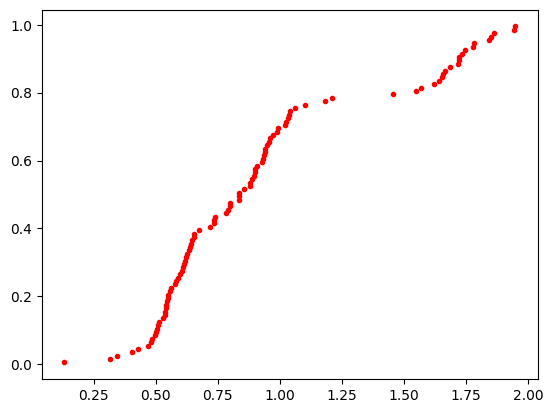

In [9]:
plot.plot(samp,quant, '.', c='red')

In [10]:
xSym = Symbol('x')
zSym = Symbol('z')

In [11]:
probMap = LogRatio(xSym,zSym,xRange=(0,2))

In [12]:
sampZ = tuple(probMap.Forward(x) for x in samp)

In [13]:
zMin,zMax = (sampZ[0], sampZ[nSamp - 1])
zMin,zMax

(-2.6592330207452384, 3.6423842496368257)

In [14]:
ArcTan = lambda q: log(q / (1 - q))
quantArcTan = tuple(ArcTan(q) for q in quant)

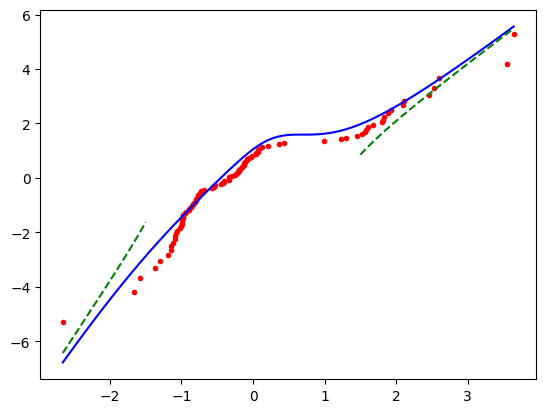

In [15]:
plot.plot(sampZ,quantArcTan, '.', c='red')

zGrid = Grid1(zMin,zMax, nPlot)
cGrid = tuple(ArcTan(dist.Cdf(probMap.Inverse(z))) for z in zGrid)
plot.plot(zGrid,cGrid, c='blue')

zGrid = Grid1(zMin,-1.5, nPlot)
left = lambda z: 27/4 * pi**2 * exp(4*z)
leftL = tuple(ArcTan(left(z)) for z in zGrid)
plot.plot(zGrid,leftL, '--',c='green')

zGrid = Grid1(1.5,zMax, nPlot)
right = lambda z: 1 - 6*exp(-2*z)
rightL = tuple(ArcTan(right(z)) for z in zGrid)
plot.plot(zGrid,rightL, '--',c='green')

## Estimate Asymptotes from Samples

### Use Simple Linear Fit

In [16]:
minEnd = round(0 * nSamp)
maxEnd = round(0.16 * nSamp)

#### Left

In [17]:
leftIndex = range(minEnd, maxEnd)
leftSampZ = Sub(sampZ, leftIndex)
leftLogQ = tuple(log(x) for x in Sub(quant, leftIndex))

In [18]:
simpleFit = curve_fit(lambda z,a0,a1: a0 + a1*z, leftSampZ,leftLogQ)
a0, a1 = simpleFit[0]
a0, a1

(-0.0655338507196335, 2.141302371969665)

In [19]:
leftAsym = lambda z: exp(a0) * exp(a1*z)

In [20]:
leftZMax = fsolve(lambda z: leftAsym(z[0]) - 0.5, 3)[0]
leftZMax

-0.2930988813424819

#### Right

In [21]:
rightIndex = range(nSamp - maxEnd, nSamp - minEnd)
rightSampZ = Sub(sampZ, rightIndex)
rightLogQ = tuple(-log(1 - x) for x in Sub(quant, rightIndex))

In [22]:
simpleFit = curve_fit(lambda z,b0,b1: (b0 + b1*z), rightSampZ,rightLogQ)
b0, b1 = simpleFit[0]
b0, b1

(-0.26505529839599795, 1.4188699129418774)

In [23]:
rightAsym = lambda z: 1 - exp(-b0) * exp(-b1*z)

In [24]:
rightZMax = fsolve(lambda z: rightAsym(z[0]) - 0.5, 2)[0]
rightZMax

0.6753279283857753

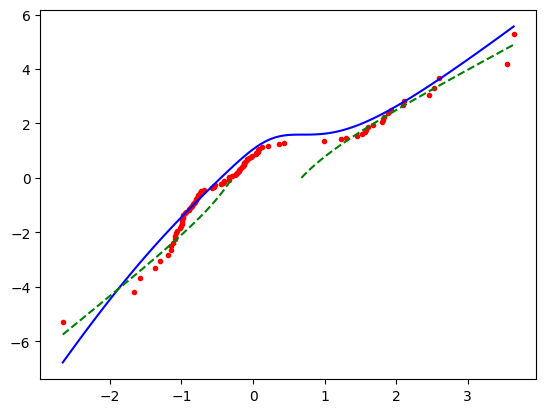

In [25]:
plot.plot(sampZ,quantArcTan, '.', c='red')

zGrid = Grid1(zMin,zMax, nPlot)
cGrid = tuple(ArcTan(dist.Cdf(probMap.Inverse(z))) for z in zGrid)
plot.plot(zGrid,cGrid, c='blue')

zGrid = Grid1(zMin,leftZMax, nPlot)
leftL = tuple(ArcTan(leftAsym(z)) for z in zGrid)
plot.plot(zGrid,leftL, '--',c='green')

zGrid = Grid1(rightZMax,zMax, nPlot)
rightL = tuple(ArcTan(rightAsym(z)) for z in zGrid)
plot.plot(zGrid,rightL, '--',c='green')

## Make Nullifyer

In [26]:
a0Sym = Symbol('a0')
a1Sym = Symbol('a1')
b0Sym = Symbol('b0')
b1Sym = Symbol('b1')

In [27]:
nullZForm = \
	(sp.exp((a1Sym + b1Sym) * zSym) + a0Sym * sp.exp(a1Sym * zSym)) / \
	(sp.exp((a1Sym + b1Sym) * zSym) + (a0Sym + b0Sym) * sp.exp(a1Sym * zSym) + 1)
nullZForm

(a0*exp(a1*z) + exp(z*(a1 + b1)))/((a0 + b0)*exp(a1*z) + exp(z*(a1 + b1)) + 1)

In [28]:
param = {'a0': exp(a0), 'a1': a1, 'b0': exp(-b0), 'b1': b1}
param

{'a0': 0.9365673427444919,
 'a1': 2.141302371969665,
 'b0': 1.3035030554135492,
 'b1': 1.4188699129418774}

In [29]:
(1 - sp.exp(-b0) * sp.exp(-b1*zSym))

1 - 1.30350305541355*exp(-1.41886991294188*z)

In [30]:
nullZSym = nullZForm.subs(param).simplify()
nullZSym

(0.936567342744492*exp(2.14130237196966*z) + exp(3.56017228491154*z))/(2.24007039815804*exp(2.14130237196966*z) + exp(3.56017228491154*z) + 1)

In [31]:
nullZ = lambdify(zSym, nullZSym)

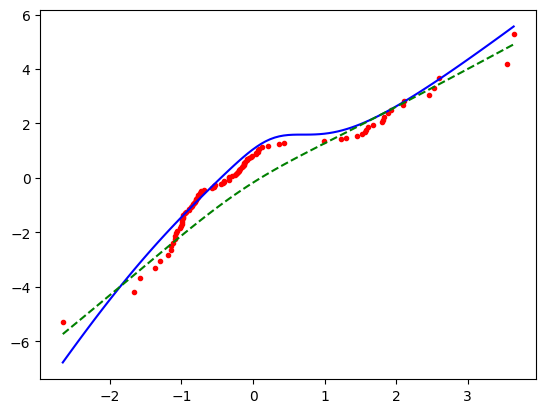

In [32]:
plot.plot(sampZ,quantArcTan, '.', c='red')

zGrid = Grid1(zMin,zMax, nPlot)
cGrid = tuple(ArcTan(dist.Cdf(probMap.Inverse(z))) for z in zGrid)
plot.plot(zGrid,cGrid, c='blue')

null = tuple(ArcTan(nullZ(z)) for z in zGrid)
plot.plot(zGrid,null, '--',c='green')

## Residual

In [33]:
res = [q - nullZ(z) for (z,q) in zip(sampZ,quant)]

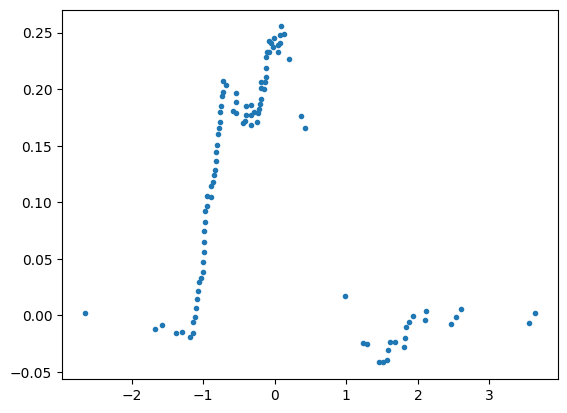

In [34]:
plot.plot(sampZ,res, '.')

## Fit

In [35]:
zMin,zMax

(-2.6592330207452384, 3.6423842496368257)

In [50]:
nSinc = 10
zRange = zMax - zMin
h = zRange / (nSinc - 1)

In [51]:
sincPointZ = [zRange * k / (nSinc - 1) + zMin for k in range(nSinc)]
sincPointZ

[-2.6592330207452384,
 -1.95905332403612,
 -1.258873627327002,
 -0.558693930617884,
 0.1414857660912343,
 0.8416654628003526,
 1.5418451595094704,
 2.2420248562185887,
 2.942204552927707,
 3.6423842496368253]

In [52]:
mat = []

for z in sampZ:
	row = []
	for sp in sincPointZ:
		row.append(sinc((z - sp) / h))
	  
	mat.append(row)

In [53]:
sincVal,residue,_,singVal = lstsq(mat, res)
sincVal

array([ 0.02132265, -0.0097565 , -0.00613124,  0.18606825,  0.21398104,
        0.10336086, -0.04757727,  0.02744333, -0.07970769,  0.0121217 ])

This is the condition number

In [54]:
singVal[0] / singVal[nSinc - 1]

7.560920608053585

In [55]:
zGrid = Grid1(-3,4, nPlot)
resGrid = []

for z in zGrid:
	val = 0
	for k in range(nSinc):
		val += sincVal[k] * sinc((z - sincPointZ[k]) / h)
	
	resGrid.append(val)

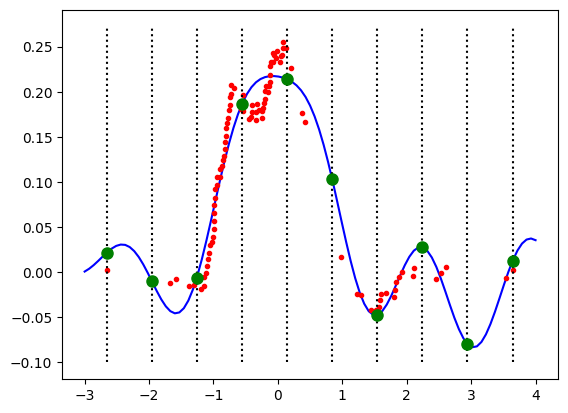

In [56]:
plot.plot(zGrid,resGrid, c='blue')
	
plot.plot(sampZ, res, '.', c='red')

yRange = plot.ylim()
for sp in sincPointZ:
	plot.plot((sp,sp), yRange, ':', c='black')
	
plot.plot(sincPointZ, sincVal, 'o', markersize=8, c='green')